# OverNaN: Handling Missing Values in Imbalanced Classification

This notebook compares three approaches to handling missing values in imbalanced classification:

| Approach | Description | Trade-off |
|----------|-------------|------------|
| **A. Drop Features** | Remove features containing NaN, then apply SMOTE | Loses feature information |
| **B. Imputation** | Fill NaN with median values, then apply SMOTE | Introduces artificial values |
| **C. SMOTENaN** | Native NaN-aware oversampling | Preserves missingness patterns |

## Dataset

We use bond and ring statistics from hexagonal graphene oxide nanoflakes to predict the presence or absence of carboxyl (COOH) functional groups.  This data set is a subset of a larger graphene oxide data set, including only large hexagonal nanoflakes (C = 1014) and features based on bonding and ring statistics.

### Why Carboxyl Concentration?

Carboxyl groups are chemically significant functional groups that affect the properties and reactivity of graphene oxide:

- **Surface chemistry**: Carboxyl groups are rare, but influence hydrophilicity, dispersibility, and chemical reactivity
- **Natural binary target**: 200 structures have no carboxyl groups, 576 have carboxyl groups present
- **Imbalanced classes**: The 2.9:1 ratio reflects real-world scenarios where one outcome is more common
- **Challenging prediction**: Carboxyl presence requires learning subtle structural patterns

The bond and ring statistics describe local atomic environments and connectivity patterns. Missing values arise naturally when certain bond types or ring configurations are absent in specific structures, making this an ideal test case for NaN-aware oversampling. The missingness is not due to failed experiments, but due to the non-existance of certain features in certain nanostructures (e.g. an O-O bond length, in a nanostructure with no O-O bonds).


In [2]:
# =============================================================================
# Imports and Configuration
# =============================================================================

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Core ML imports
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, balanced_accuracy_score, roc_auc_score
)

# Classifier (XGBoost handles NaN natively)
from xgboost import XGBClassifier

# Standard SMOTE for comparison
from imblearn.over_sampling import SMOTE

# OverNaN
from overnan import SMOTENaN

# Visualization
import matplotlib.pyplot as plt

# =============================================================================
# Configuration
# =============================================================================
RANDOM_STATE = 42
N_SPLITS = 5

print("Configuration:")
print(f"  Random State: {RANDOM_STATE}")
print(f"  CV Folds:     {N_SPLITS}")
print(f"  Classifier:   XGBoost")

Configuration:
  Random State: 42
  CV Folds:     5
  Classifier:   XGBoost


In [3]:
# =============================================================================
# Cell 2: Load and Prepare Data
# =============================================================================

# Load dataset
df = pd.read_csv('grapheneoxide.csv')

print("="*70)
print("GRAPHENE OXIDE NANOFLAKES DATASET")
print("="*70)
print(f"\nRaw dataset: {df.shape[0]} samples x {df.shape[1]} columns")

# -------------------------------------------------------------------------
# Create target: Carboxyl group presence (binary)
# -------------------------------------------------------------------------
y = (df['carboxyl_concentration'] > 0).astype(int).values

print(f"\n--- Target Variable ---")
print(f"Class 0 (no carboxyl):  {np.sum(y == 0)} samples")
print(f"Class 1 (has carboxyl): {np.sum(y == 1)} samples")
print(f"Imbalance ratio:        {np.sum(y == 1) / np.sum(y == 0):.2f}:1")

# -------------------------------------------------------------------------
# Prepare features: Bond and ring statistics only
# -------------------------------------------------------------------------
# Drop non-feature columns
drop_cols = ['file_name','carboxyl_concentration']
X = df.drop(columns=drop_cols)

# Remove features that are 100% NaN (uninformative)
nan_counts = X.isna().sum()
X = X.loc[:, nan_counts < len(X)]
print(f"\nAfter removing 100% NaN features: {X.shape[1]} features")

# Select bond and ring statistics
bond_cols = [c for c in X.columns if ':' in c and 
             any(c.startswith(p) for p in ['C-C', 'C-H', 'C-O', 'H-O', 'O-O', 'H-C', 'O-C', 'O-H'])]
ring_cols = [c for c in X.columns if 'ring' in c.lower()]
selected_cols = bond_cols + ring_cols
X = X[selected_cols]

print(f"After selecting bond/ring features: {X.shape[1]} features")
print(f"  Bond statistics: {len(bond_cols)}")
print(f"  Ring statistics: {len(ring_cols)}")

# -------------------------------------------------------------------------
# Convert to numpy and compute statistics
# -------------------------------------------------------------------------
feature_names = X.columns.tolist()
X = X.values.astype(np.float64)

# NaN statistics
nan_per_feature = np.isnan(X).sum(axis=0)
features_with_nan = np.sum(nan_per_feature > 0)
features_without_nan = np.sum(nan_per_feature == 0)
overall_nan_rate = 100 * np.isnan(X).sum() / X.size
samples_with_nan = np.sum(np.any(np.isnan(X), axis=1))

print(f"\n" + "="*70)
print("FINAL DATASET SUMMARY")
print("="*70)
print(f"Samples:              {X.shape[0]}")
print(f"Features:             {X.shape[1]}")
print(f"Class 0 (no COOH):    {np.sum(y == 0)}")
print(f"Class 1 (has COOH):   {np.sum(y == 1)}")
print(f"Imbalance ratio:      {np.sum(y == 1) / np.sum(y == 0):.2f}:1")
print(f"Features with NaN:    {features_with_nan} ({100*features_with_nan/X.shape[1]:.0f}%)")
print(f"Features without NaN: {features_without_nan} ({100*features_without_nan/X.shape[1]:.0f}%)")
print(f"Samples with NaN:     {samples_with_nan} ({100*samples_with_nan/X.shape[0]:.0f}%)")
print(f"Overall NaN rate:     {overall_nan_rate:.1f}%")
print("="*70)

GRAPHENE OXIDE NANOFLAKES DATASET

Raw dataset: 776 samples x 508 columns

--- Target Variable ---
Class 0 (no carboxyl):  200 samples
Class 1 (has carboxyl): 576 samples
Imbalance ratio:        2.88:1

After removing 100% NaN features: 475 features
After selecting bond/ring features: 232 features
  Bond statistics: 192
  Ring statistics: 40

FINAL DATASET SUMMARY
Samples:              776
Features:             232
Class 0 (no COOH):    200
Class 1 (has COOH):   576
Imbalance ratio:      2.88:1
Features with NaN:    123 (53%)
Features without NaN: 109 (47%)
Samples with NaN:     776 (100%)
Overall NaN rate:     39.8%


In [4]:
# =============================================================================
# Evaluation Framework
# =============================================================================

def evaluate_approach(X, y, preprocess_fn, approach_name, n_splits=N_SPLITS, random_state=RANDOM_STATE):
    """
    Evaluate a preprocessing approach using stratified k-fold cross-validation.
    
    Parameters
    ----------
    X : np.ndarray
        Feature matrix (may contain NaN).
    y : np.ndarray
        Target labels.
    preprocess_fn : callable
        Function: (X_train, y_train, X_test) -> (X_train_proc, y_train_proc, X_test_proc)
    approach_name : str
        Name for display.
    n_splits : int
        Number of CV folds.
    random_state : int
        Random seed.
    
    Returns
    -------
    dict : Results with mean and std for each metric.
    """
    metrics = {
        'accuracy': [], 'balanced_accuracy': [], 'precision': [],
        'recall': [], 'f1': [], 'roc_auc': []
    }
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx].copy(), X[test_idx].copy()
        y_train, y_test = y[train_idx].copy(), y[test_idx].copy()
        
        # Apply preprocessing
        try:
            X_train_proc, y_train_proc, X_test_proc = preprocess_fn(X_train, y_train, X_test)
        except Exception as e:
            print(f"  Fold {fold+1}: Error - {e}")
            continue
        
        if X_train_proc is None or X_train_proc.shape[0] == 0 or X_train_proc.shape[1] == 0:
            print(f"  Fold {fold+1}: Preprocessing failed")
            continue
        
        # Train classifier
        clf = XGBClassifier(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.1,
            random_state=random_state + fold,
            eval_metric='logloss',
            verbosity=0
        )
        clf.fit(X_train_proc, y_train_proc)
        
        # Predict and evaluate
        y_pred = clf.predict(X_test_proc)
        y_prob = clf.predict_proba(X_test_proc)[:, 1]
        
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['balanced_accuracy'].append(balanced_accuracy_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_test, y_pred, zero_division=0))
        metrics['f1'].append(f1_score(y_test, y_pred, zero_division=0))
        metrics['roc_auc'].append(roc_auc_score(y_test, y_prob))
    
    # Compute summary statistics
    results = {}
    for metric_name, values in metrics.items():
        if len(values) > 0:
            results[f'{metric_name}_mean'] = np.mean(values)
            results[f'{metric_name}_std'] = np.std(values)
        else:
            results[f'{metric_name}_mean'] = np.nan
            results[f'{metric_name}_std'] = np.nan
    results['n_successful_folds'] = len(metrics['accuracy'])
    
    return results

print("Evaluation framework ready.")
print(f"  Cross-validation: {N_SPLITS}-fold stratified")
print(f"  Classifier: XGBoost (n_estimators=100, max_depth=4)")
print(f"  Metrics: Accuracy, Balanced Accuracy, Precision, Recall, F1, ROC-AUC")

Evaluation framework ready.
  Cross-validation: 5-fold stratified
  Classifier: XGBoost (n_estimators=100, max_depth=4)
  Metrics: Accuracy, Balanced Accuracy, Precision, Recall, F1, ROC-AUC


In [5]:
# =============================================================================
# Approach A - Drop Features with NaN + SMOTE
# =============================================================================
# Remove any feature containing at least one NaN, then apply standard SMOTE.
# Trade-off: Loses potentially informative features.

def preprocess_drop_features(X_train, y_train, X_test):
    """
    Drop features containing any NaN, then apply SMOTE.
    """
    # Identify features without NaN in training data
    nan_mask = np.any(np.isnan(X_train), axis=0)
    features_to_keep = ~nan_mask
    
    X_train_clean = X_train[:, features_to_keep]
    X_test_clean = X_test[:, features_to_keep]
    
    if X_train_clean.shape[1] == 0:
        return None, None, None
    
    # Apply SMOTE (minority class is class 0: no carboxyl)
    min_class_count = min(np.sum(y_train == 0), np.sum(y_train == 1))
    k_neighbors = min(5, min_class_count - 1)
    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)
    X_train_res, y_train_res = smote.fit_resample(X_train_clean, y_train)
    
    return X_train_res, y_train_res, X_test_clean


print("Approach A: Drop Features + SMOTE")
print("="*50)

# Report feature retention
nan_mask = np.any(np.isnan(X), axis=0)
n_kept = np.sum(~nan_mask)
print(f"Features retained: {n_kept}/{X.shape[1]} ({100*n_kept/X.shape[1]:.0f}%)")
print(f"Features dropped:  {X.shape[1] - n_kept}")

results_A = evaluate_approach(X, y, preprocess_drop_features, "Drop Features")

print(f"\nResults ({results_A['n_successful_folds']}/{N_SPLITS} folds):")
print(f"  Balanced Accuracy: {results_A['balanced_accuracy_mean']:.3f} +/- {results_A['balanced_accuracy_std']:.3f}")
print(f"  F1 Score:          {results_A['f1_mean']:.3f} +/- {results_A['f1_std']:.3f}")
print(f"  ROC-AUC:           {results_A['roc_auc_mean']:.3f} +/- {results_A['roc_auc_std']:.3f}")

Approach A: Drop Features + SMOTE
Features retained: 109/232 (47%)
Features dropped:  123

Results (5/5 folds):
  Balanced Accuracy: 0.940 +/- 0.027
  F1 Score:          0.974 +/- 0.010
  ROC-AUC:           0.991 +/- 0.006


In [6]:
# =============================================================================
# Approach B - Imputation + SMOTE
# =============================================================================
# Fill NaN values with median, then apply standard SMOTE.
# Trade-off: Introduces artificial values that may not reflect true data.

def preprocess_imputation(X_train, y_train, X_test):
    """
    Impute NaN with median values, then apply SMOTE.
    """
    # Fit imputer on training data
    imputer = SimpleImputer(strategy='median')
    X_train_imp = imputer.fit_transform(X_train)
    X_test_imp = imputer.transform(X_test)
    
    # Apply SMOTE
    min_class_count = min(np.sum(y_train == 0), np.sum(y_train == 1))
    k_neighbors = min(5, min_class_count - 1)
    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)
    X_train_res, y_train_res = smote.fit_resample(X_train_imp, y_train)
    
    return X_train_res, y_train_res, X_test_imp


print("Approach B: Imputation (Median) + SMOTE")
print("="*50)

total_nan = np.isnan(X).sum()
print(f"NaN values imputed: {total_nan} ({100*np.isnan(X).mean():.1f}% of data)")
print(f"Features retained:  {X.shape[1]}/{X.shape[1]} (100%)")

results_B = evaluate_approach(X, y, preprocess_imputation, "Imputation")

print(f"\nResults ({results_B['n_successful_folds']}/{N_SPLITS} folds):")
print(f"  Balanced Accuracy: {results_B['balanced_accuracy_mean']:.3f} +/- {results_B['balanced_accuracy_std']:.3f}")
print(f"  F1 Score:          {results_B['f1_mean']:.3f} +/- {results_B['f1_std']:.3f}")
print(f"  ROC-AUC:           {results_B['roc_auc_mean']:.3f} +/- {results_B['roc_auc_std']:.3f}")

Approach B: Imputation (Median) + SMOTE
NaN values imputed: 71721 (39.8% of data)
Features retained:  232/232 (100%)

Results (5/5 folds):
  Balanced Accuracy: 0.987 +/- 0.025
  F1 Score:          0.995 +/- 0.008
  ROC-AUC:           1.000 +/- 0.001


In [7]:
# =============================================================================
# Approach C - SMOTENaN (Native NaN Handling)
# =============================================================================
# Use OverNaN's SMOTENaN which handles missing values natively.
# Trade-off: None - preserves both features and samples with their NaN patterns.

def preprocess_smotenan(X_train, y_train, X_test):
    """
    Apply SMOTENaN which handles NaN natively.
    """
    min_class_count = min(np.sum(y_train == 0), np.sum(y_train == 1))
    k_neighbors = min(5, min_class_count - 1)
    
    smotenan = SMOTENaN(
        neighbours=k_neighbors,
        random_state=RANDOM_STATE,
        nan_handling='preserve_pattern'
    )
    X_train_res, y_train_res = smotenan.fit_resample(X_train, y_train)
    
    return X_train_res, y_train_res, X_test


print("Approach C: SMOTENaN (Native NaN Handling)")
print("="*50)

print(f"NaN handling:       preserve_pattern")
print(f"Features retained:  {X.shape[1]}/{X.shape[1]} (100%)")
print(f"Samples retained:   {X.shape[0]}/{X.shape[0]} (100%)")

results_C = evaluate_approach(X, y, preprocess_smotenan, "SMOTENaN")

print(f"\nResults ({results_C['n_successful_folds']}/{N_SPLITS} folds):")
print(f"  Balanced Accuracy: {results_C['balanced_accuracy_mean']:.3f} +/- {results_C['balanced_accuracy_std']:.3f}")
print(f"  F1 Score:          {results_C['f1_mean']:.3f} +/- {results_C['f1_std']:.3f}")
print(f"  ROC-AUC:           {results_C['roc_auc_mean']:.3f} +/- {results_C['roc_auc_std']:.3f}")

Approach C: SMOTENaN (Native NaN Handling)
NaN handling:       preserve_pattern
Features retained:  232/232 (100%)
Samples retained:   776/776 (100%)

Results (5/5 folds):
  Balanced Accuracy: 0.997 +/- 0.005
  F1 Score:          0.999 +/- 0.002
  ROC-AUC:           0.997 +/- 0.005


In [8]:
# =============================================================================
# Results Comparison
# =============================================================================

approaches = {
    'A: Drop Features': results_A,
    'B: Imputation': results_B,
    'C: SMOTENaN': results_C
}

# Build comparison table
comparison_data = []
for name, res in approaches.items():
    row = {'Approach': name, 'Folds': res['n_successful_folds']}
    for metric in ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        mean_val = res[f'{metric}_mean']
        std_val = res[f'{metric}_std']
        if np.isnan(mean_val):
            row[metric.replace('_', ' ').title()] = 'FAILED'
        else:
            row[metric.replace('_', ' ').title()] = f"{mean_val:.3f} +/- {std_val:.3f}"
    comparison_data.append(row)

results_df = pd.DataFrame(comparison_data)

print("="*80)
print("RESULTS COMPARISON")
print("="*80)
print(f"\nDataset: Graphene Oxide Nanoflakes")
print(f"Target:  Carboxyl group presence (0=absent, 1=present)")
print(f"Samples: {X.shape[0]}, Features: {X.shape[1]}, NaN Rate: {100*np.isnan(X).mean():.1f}%")
print(f"Class Distribution: {np.sum(y==0)} no-COOH vs {np.sum(y==1)} has-COOH ({np.sum(y==1)/np.sum(y==0):.1f}:1)")
print(f"Evaluation: {N_SPLITS}-fold stratified cross-validation\n")

print(results_df.to_string(index=False))

# Identify best approach
print("\n" + "-"*80)
valid_approaches = [(name, res) for name, res in approaches.items() 
                    if not np.isnan(res['balanced_accuracy_mean'])]

if valid_approaches:
    best_name, best_res = max(valid_approaches, key=lambda x: x[1]['balanced_accuracy_mean'])
    print(f"\nBest Approach (by Balanced Accuracy): {best_name}")
    print(f"  Balanced Accuracy: {best_res['balanced_accuracy_mean']:.3f}")
    print(f"  F1 Score:          {best_res['f1_mean']:.3f}")
    print(f"  ROC-AUC:           {best_res['roc_auc_mean']:.3f}")

RESULTS COMPARISON

Dataset: Graphene Oxide Nanoflakes
Target:  Carboxyl group presence (0=absent, 1=present)
Samples: 776, Features: 232, NaN Rate: 39.8%
Class Distribution: 200 no-COOH vs 576 has-COOH (2.9:1)
Evaluation: 5-fold stratified cross-validation

        Approach  Folds        Accuracy Balanced Accuracy       Precision          Recall              F1         Roc Auc
A: Drop Features      5 0.961 +/- 0.015   0.940 +/- 0.027 0.965 +/- 0.020 0.984 +/- 0.019 0.974 +/- 0.010 0.991 +/- 0.006
   B: Imputation      5 0.992 +/- 0.013   0.987 +/- 0.025 0.992 +/- 0.017 0.998 +/- 0.003 0.995 +/- 0.008 1.000 +/- 0.001
     C: SMOTENaN      5 0.999 +/- 0.003   0.997 +/- 0.005 0.998 +/- 0.003 1.000 +/- 0.000 0.999 +/- 0.002 0.997 +/- 0.005

--------------------------------------------------------------------------------

Best Approach (by Balanced Accuracy): C: SMOTENaN
  Balanced Accuracy: 0.997
  F1 Score:          0.999
  ROC-AUC:           0.997


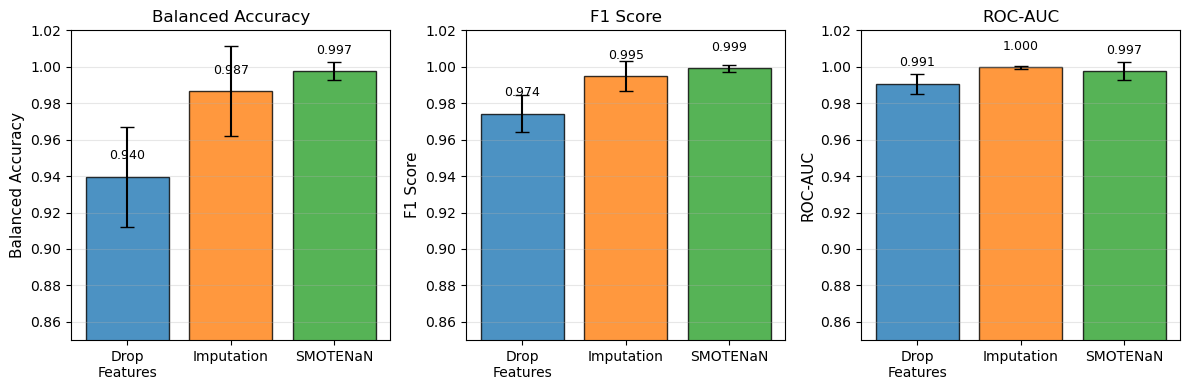

Figure saved: overnan_grapheneoxide_comparison.png


In [9]:
# =============================================================================
# Visualization
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

metrics_to_plot = [
    ('balanced_accuracy', 'Balanced Accuracy'),
    ('f1', 'F1 Score'),
    ('roc_auc', 'ROC-AUC')
]

approach_names = list(approaches.keys())
colors = plt.get_cmap('tab10').colors[:3]

for ax, (metric, title) in zip(axes, metrics_to_plot):
    means = [approaches[name][f'{metric}_mean'] for name in approach_names]
    stds = [approaches[name][f'{metric}_std'] for name in approach_names]
    
    # Handle NaN
    means_plot = [m if not np.isnan(m) else 0 for m in means]
    stds_plot = [s if not np.isnan(s) else 0 for s in stds]
    
    bars = ax.bar(range(len(approach_names)), means_plot, color=colors,
                  yerr=stds_plot, capsize=5, alpha=0.8, edgecolor='black')
    
    # Mark failed approaches
    for i, m in enumerate(means):
        if np.isnan(m):
            ax.text(i, 0.05, 'FAILED', ha='center', va='bottom',
                   fontsize=9, fontweight='bold', color='red')
    
    ax.set_xticks(range(len(approach_names)))
    ax.set_xticklabels(['Drop\nFeatures', 'Imputation', 'SMOTENaN'], fontsize=10)
    ax.set_ylabel(title, fontsize=11)
    ax.set_ylim(0.85, 1.02)
    ax.set_title(title, fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (bar, m) in enumerate(zip(bars, means)):
        if not np.isnan(m):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.008,
                   f'{m:.3f}', ha='center', va='bottom', fontsize=9)
            
plt.tight_layout()
plt.savefig('overnan_grapheneoxide_comparisons.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("Figure saved: overnan_grapheneoxide_comparison.png")

In [10]:
# =============================================================================
# Summary of Results
# =============================================================================

print("="*80)
print("SUMMARY")
print("="*80)

# Data retention comparison
nan_mask = np.any(np.isnan(X), axis=0)
n_features_kept = np.sum(~nan_mask)

print("""
DATA RETENTION
--------------
                     Features    Samples    Information Loss
A: Drop Features     {0:>3}/{1:<3}       {2}/{2}      Loses {3:.0f}% of features
B: Imputation        {1}/{1}       {2}/{2}      Replaces {4:.0f}% of values
C: SMOTENaN          {1}/{1}       {2}/{2}      None (preserves NaN)
""".format(
    n_features_kept, X.shape[1], X.shape[0],
    100*(1 - n_features_kept/X.shape[1]),
    100*np.isnan(X).mean()
))

print("""
KEY FINDINGS
------------
1. DROP FEATURES loses {0:.0f}% of features by removing any with NaN.
   This information loss impacts classification performance.

2. IMPUTATION replaces {1:.0f}% of the data with artificial median values.
   While all features are retained, the imputed values may not reflect the true underlying patterns.

3. SMOTENaN preserves 100% of features AND respects the NaN structure.
   Combined with XGBoost (which handles NaN natively), this achieves the best classification performance.

RECOMMENDATION
--------------
For datasets with meaningful missing values (such as materials data where
NaN indicates absence of specific structural features), SMOTENaN provides the best balance of information preservation and classification accuracy.
""".format(
    100*(1 - n_features_kept/X.shape[1]),
    100*np.isnan(X).mean()
))

print("="*80)

SUMMARY

DATA RETENTION
--------------
                     Features    Samples    Information Loss
A: Drop Features     109/232       776/776      Loses 53% of features
B: Imputation        232/232       776/776      Replaces 40% of values
C: SMOTENaN          232/232       776/776      None (preserves NaN)


KEY FINDINGS
------------
1. DROP FEATURES loses 53% of features by removing any with NaN.
   This information loss impacts classification performance.

2. IMPUTATION replaces 40% of the data with artificial median values.
   While all features are retained, the imputed values may not reflect the true underlying patterns.

3. SMOTENaN preserves 100% of features AND respects the NaN structure.
   Combined with XGBoost (which handles NaN natively), this achieves the best classification performance.

RECOMMENDATION
--------------
For datasets with meaningful missing values (such as materials data where
NaN indicates absence of specific structural features), SMOTENaN provides the bes

## Method Comparison

| Approach | Pros | Cons |
|----------|------|------|
| **Drop Features** | Simple, no imputation bias | Loses informative features |
| **Imputation** | Retains all features | Introduces artificial values |
| **SMOTENaN** | Preserves all information and NaN structure | Requires NaN-aware classifier |

## References

1. **SMOTE**: Chawla, N.V., Bowyer, K.W., Hall, L.O., Kegelmeyer, W.P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. *Journal of Artificial Intelligence Research*, 16, 321-357. DOI: [10.1613/jair.953](https://doi.org/10.1613/jair.953)

2. **ADASYN**: He, H., Bai, Y., Garcia, E.A., Li, S. (2008). ADASYN: Adaptive Synthetic Sampling Approach for Imbalanced Learning. *IEEE IJCNN*, 1322-1328. DOI: [10.1109/IJCNN.2008.4633969](https://doi.org/10.1109/IJCNN.2008.4633969)

3. **ROSE**: Menardi, G. and Torelli, N. (2014). Training and assessing classification rules with imbalanced data. *Data Mining and Knowledge Discovery*, 28, 92-122. DOI: [10.1007/s10618-012-0295-5](https://doi.org/10.1007/s10618-012-0295-5)
   
5. **DATA**: Barnard A., Motevalli, B., Sun, B., Lai, L. (2019). Neutral Graphene Oxide Data Set. v1. *CSIRO Data Collection*, DOI: [10.25919/5e30b44a7c948](https://doi.org/10.25919/5e30b44a7c948).